# Plotting cross slope heat transport in easterlies

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/Antarctic_cross_slope/depth_int_heat_trans/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39581,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.57 GiB
Comm: tcp://10.6.41.70:39293,Total threads: 6
Dashboard: /proxy/33351/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:40267,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

first_year = 2150
last_year = 2164


In [5]:
# open UP data:

save_dir = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/Antarctic_cross_slope/'

# set up arrays to write into:
n_years = last_year - first_year + 1
# open example to get coords:
file = save_dir+'vol_trans_across_contour_2150_01.nc'
data_this_month = xr.open_dataset(file)
vol_trans_across_contour1 = data_this_month.vol_trans_across_contour_binned

vol_trans_across_contour = xr.DataArray(np.zeros((len(vol_trans_across_contour1.isopycnal_bins),len(vol_trans_across_contour1.contour_index))), 
                                       coords = [vol_trans_across_contour1.isopycnal_bins, vol_trans_across_contour1.contour_index], 
                                       dims = ['isopycnal_bins', 'contour_index'], 
                                       name = 'vol_trans_across_contour')

# compute time mean:
ndays_total = 0
for year in range(first_year,last_year+1):
    for month in range(12):
        file = save_dir+'vol_trans_across_contour_'+str(year)+'_'+str(month+1).zfill(2)+'.nc'
        #print('Opening '+file)
        data_this_month = xr.open_dataset(file)
         # extract arrays from dataset:
        ndays_this_month = data_this_month.ndays
        vol_trans_across_contour += (data_this_month.vol_trans_across_contour_binned)*ndays_this_month
        ndays_total += ndays_this_month

vol_trans_across_contour_up = vol_trans_across_contour/ndays_total

In [6]:
# open DOWN data:

save_dir = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/Antarctic_cross_slope/'

# set up arrays to write into:
n_years = last_year - first_year + 1
# open example to get coords:
file = save_dir+'vol_trans_across_contour_2150_01.nc'
data_this_month = xr.open_dataset(file)
vol_trans_across_contour1 = data_this_month.vol_trans_across_contour_binned

vol_trans_across_contour = xr.DataArray(np.zeros((len(vol_trans_across_contour1.isopycnal_bins),len(vol_trans_across_contour1.contour_index))), 
                                       coords = [vol_trans_across_contour1.isopycnal_bins, vol_trans_across_contour1.contour_index], 
                                       dims = ['isopycnal_bins', 'contour_index'], 
                                       name = 'vol_trans_across_contour')

# compute time mean:
ndays_total = 0
for year in range(first_year,last_year+1):
    for month in range(12):
        file = save_dir+'vol_trans_across_contour_'+str(year)+'_'+str(month+1).zfill(2)+'.nc'
        #print('Opening '+file)
        data_this_month = xr.open_dataset(file)
         # extract arrays from dataset:
        ndays_this_month = data_this_month.ndays
        vol_trans_across_contour += (data_this_month.vol_trans_across_contour_binned)*ndays_this_month
        ndays_total += ndays_this_month

vol_trans_across_contour_down = vol_trans_across_contour/ndays_total

(32.8, 31.0)

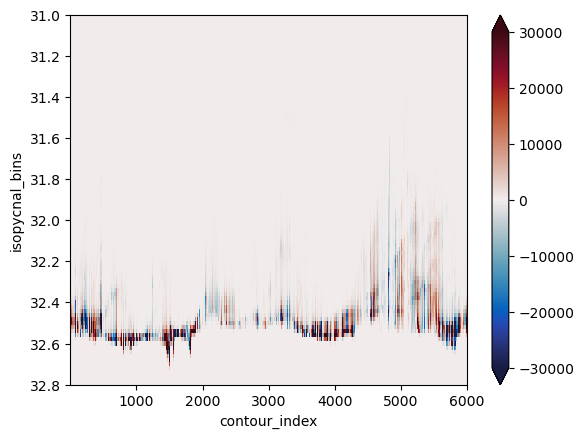

In [15]:
# What does the whole data look like?
vol_trans_across_contour.plot(vmin=-30000,vmax=30000,cmap=cmocean.balance)
plt.ylim(32.8,31)


Text(0, 0.5, '$\\sigma_1$')

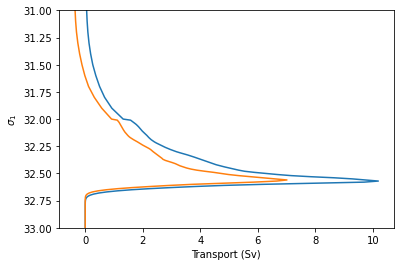

In [7]:
# sum circumpolarly along contour index:
trans_sum_up = vol_trans_across_contour_up.sum('contour_index')
trans_sum_down = vol_trans_across_contour_down.sum('contour_index')

# compute streamfunction, sum vertically from bottom up:
psi_up = trans_sum_up[::-1].cumsum('isopycnal_bins')[::-1]
psi_down = trans_sum_down[::-1].cumsum('isopycnal_bins')[::-1]


plt.plot(psi_up/1e6,psi_up.isopycnal_bins)
plt.plot(psi_down/1e6,psi_down.isopycnal_bins)
plt.ylim(33,31)
plt.xlabel('Transport (Sv)')
plt.ylabel('$\sigma_1$')

Text(0, 0.5, 'DSW transport (Sv)')

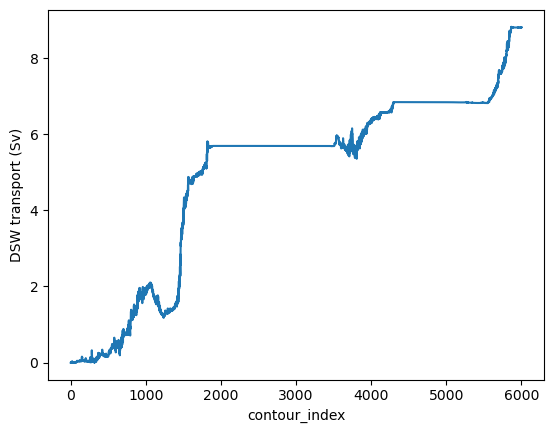

In [42]:
# plot cumulative sum of DSW transport along contour:

# find max DSW density:
DSW_top_density = psi.argmax()

# sum over DSW layer:
DSW_trans = vol_trans_across_contour.isel(isopycnal_bins=slice(int(DSW_top_density),None)).sum('isopycnal_bins')

(DSW_trans.cumsum('contour_index')/1e6).plot()
plt.ylabel('DSW transport (Sv)')